In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [18]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()

In [19]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [20]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Text(0.5, 1.0, 'Hawaii Prcp over last 12 months')

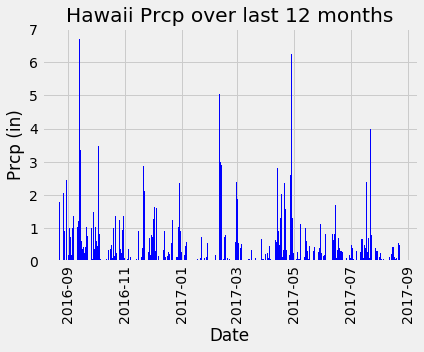

In [23]:
# Precipitation Analysis

# Design a query to retrieve the last 12 months of precipitation data 

# Calculate last date in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#converting to datetime format
last_date = dt.date(2017, 8, 23)

# Calculate the date 1 year ago from the last data point in the database
last_year = last_date - dt.timedelta(days=365)
#year before last date = 8/23/16 from outputs

# Perform a query to retrieve the data and precipitation scores
last_year_temp_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_last_year = pd.DataFrame(last_year_temp_prcp, columns=['Date','Prcp (in)'])

# Sort the dataframe by date
df_last_year = df_last_year.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
date = df_last_year['Date'].tolist()
prcp = df_last_year['Prcp (in)'].tolist()

# Make dates readable
date = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in date]

# Plot precipitation over time
plt.bar(date, prcp, color = 'blue')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Prcp (in)')
plt.title('Hawaii Prcp over last 12 months')


In [24]:
# Use Pandas to calcualte the summary statistics for the precipitation data
avg = df_last_year['Prcp (in)'].mean()
med = df_last_year['Prcp (in)'].median()
stdev = df_last_year['Prcp (in)'].std()
var = df_last_year['Prcp (in)'].var()
sem = df_last_year['Prcp (in)'].sem()

# Make into dataframe
stats = {'Prcp Summary': ['Mean', 'Median', 'Stdev', 'Var', 'SE'],
         'Data (in)': [avg, med, stdev, var, sem]}
stats = pd.DataFrame(stats)

# Cleanup Formatting
stats["Data (in)"] = stats["Data (in)"].map("{:.3f}".format)

stats

,Prcp Summary,Data (in)
0,Mean,0.177
1,Median,0.020
2,Stdev,0.461
3,Var,0.213
4,SE,0.010


In [25]:
# Design a query to show the stations that are available in this dataset?
session.query(Measurement.station).distinct().all()

# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct().count()

9

In [26]:
# Station Analysis (whole data set)

# What are the most active stations? (i.e. what stations have the most rows)?
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).all()

# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# USC00519281 is the most active station over the 7 year span of data with 2772 temperature observations

# Filter for this station: 
st_519281 = session.query(Measurement.date, Measurement.prcp, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').all()

# Create DataFrame for this station
df_519281 = pd.DataFrame(st_519281, columns=['Date','Prcp (in)','Tobs (F)'])

# Calculate the lowest temperature recorded 
Tmin = df_519281['Tobs (F)'].min()

# Calculate the highest temperature recorded
Tmax = df_519281['Tobs (F)'].max()

# Calculate the average temperature recorded
Tavg = df_519281['Tobs (F)'].mean()

Temp_list_519281 = [Tmin, Tavg, Tmax]
Temp_list_519281

[54.0, 71.66378066378067, 85.0]

Text(0, 0.5, 'Frequency Count')

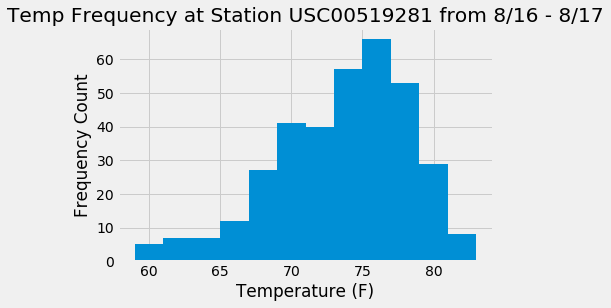

In [28]:
# Choose the station with the highest number of temperature observations.
# USC00519281 is the most active station over the 7 year span of data with 2772 temperature observations

# Query the last 12 months of temperature observation data for this station 
last_year_519281 = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.date <= '2017-08-23').all()

# Create DataFrame for this station in the last year
df_last_year_519281 = pd.DataFrame(last_year_519281, columns=['Date','Tobs (F)'])

# Plot frequency of temperatures on a histogram (use 12 bins)
df_last_year_519281.hist(bins=12)
plt.title("Temp Frequency at Station USC00519281 from 8/16 - 8/17")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency Count")

## Bonus Challenge Assignment

In [29]:
import scipy.stats as stats

# Bonus 1: Hawaii weather is perceived to be mild all year. Is this true? Verify w June/Dec temp data. 

# 1: Pull all temperature data to create master dataset
All_data = session.query(Measurement.date, Measurement.tobs).all()
All_data = pd.DataFrame(All_data, columns=['Date','Tobs (F)'])

# 2: Filter only for June Data
June_data = All_data[pd.to_datetime(All_data['Date']).dt.month == 6]
June_temp = June_data['Tobs (F)'].tolist()

# 3: Filter only for December Data
Dec_data = All_data[pd.to_datetime(All_data['Date']).dt.month == 12]
Dec_temp = Dec_data['Tobs (F)'].tolist()

# 4: Perform Independent T-Test
stats.ttest_ind(June_temp, Dec_temp)


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [40]:
June_data['Tobs (F)'].mean()
Dec_data['Tobs (F)'].mean()

means = [June_data['Tobs (F)'].mean(), Dec_data['Tobs (F)'].mean()]
means

[74.94411764705882, 71.04152933421226]

Analysis/Interpretation of independent t-test:

1) Unpaired t-test was used over paired t-test b/c two independent variables (June_temp, Dec_temp) were being checked to see if they could be from the same group or not...in other words, is there a significant difference in the mean of the two sets of temperatures or not? An unpaired t-test is better positioned to answer this question, because rephrasing it from a Hawaii vacation planning perspective, the question becomes, is there a significant difference in June and Dec temperatures? Paired t-test is better positioned to answer before/after studies, or comparing two related groups...neither of which is the case here. 

2) t-test is interpreted through hypothesis testing:
Null hypothesis - mean of June data = mean of Dec data (indication that temperature is the same in June/Dec)
Alt hypothesis - means/temps are not same in June and Dec
If p-value < 0.05, reject the null hypothesis. 

3) Conclusion
Given that the p-value = 3.9e-191, which is much less than 0.05, we can reject the null hypothesis. June and Dec mean temperature difference is statistically significant. Doing a quick mean calc (above) shows June mean of 75F and Dec mean of 71F. Per statistics, this is significant at the 95% confidence level. However; statistics aside, 75 vs. 71 F feeling on the body may not be a big difference at all...in fact temperatures during the same day would vary more. 

So taking into account both statistics and just general human feeling, one can reasonably say that while the difference in mean temperatures in June/Dec is statistically significant, it may not be kinesthetically significant enough to alter vacation plans, change clothes packed etc. b/c the difference is only 4F at temperatures > 70F.

In [31]:
# Climate App (Hawaii.app) runs this code section

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
#Bonus #2 

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [35]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [36]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [37]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [38]:
# Plot the daily normals as an area plot with `stacked=False`
